# Rainbow with Quantile Regression

## Imports

In [1]:
import gym
import numpy as np

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from IPython.display import clear_output
from matplotlib import pyplot as plt
%matplotlib inline

from timeit import default_timer as timer
from datetime import timedelta
import math

from utils.wrappers import *
from agents.DQN import Model as DQN_Agent
from utils.ReplayMemory import PrioritizedReplayMemory
from networks.layers import NoisyLinear

from utils.hyperparameters import Config

## Hyperparameters

In [2]:
config = Config()

config.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Multi-step returns
config.N_STEPS = 3

#misc agent variables
config.GAMMA=0.99
config.LR=1e-4

#memory
config.TARGET_NET_UPDATE_FREQ = 1000
config.EXP_REPLAY_SIZE = 100000
config.BATCH_SIZE = 32
config.PRIORITY_ALPHA=0.3
config.PRIORITY_BETA_START=0.4
config.PRIORITY_BETA_FRAMES = 100000

#epsilon variables
config.SIGMA_INIT=0.5

#Learning control variables
config.LEARN_START = 10000
config.MAX_FRAMES=1000000

#Quantile Regression Parameters
config.QUANTILES=51

## Network

In [3]:
class DuelingQRDQN(nn.Module):
    def __init__(self, input_shape, num_actions, sigma_init=0.5, quantiles=51):
        super(DuelingQRDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        self.quantiles=quantiles

        self.conv1 = nn.Conv2d(self.input_shape[0], 32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, stride=1)

        self.adv1 = NoisyLinear(self.feature_size(), 512, sigma_init)
        self.adv2 = NoisyLinear(512, self.num_actions*self.quantiles, sigma_init)

        self.val1 = NoisyLinear(self.feature_size(), 512, sigma_init)
        self.val2 = NoisyLinear(512, 1*self.quantiles, sigma_init)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        adv = F.relu(self.adv1(x))
        adv = self.adv2(adv).view(-1, self.num_actions, self.quantiles)

        val = F.relu(self.val1(x))
        val = self.val2(val).view(-1, 1, self.quantiles)

        return val + adv - adv.mean(dim=1).view(-1, 1, self.quantiles)
    
    def feature_size(self):
        return self.conv3(self.conv2(self.conv1(torch.zeros(1, *self.input_shape)))).view(1, -1).size(1)
    
    def sample_noise(self):
        self.adv1.sample_noise()
        self.adv2.sample_noise()
        self.val1.sample_noise()
        self.val2.sample_noise()

## Agent

In [4]:
class Model(DQN_Agent):
    def __init__(self, static_policy=False, env=None, config=None):
        self.num_quantiles = config.QUANTILES
        self.cumulative_density = torch.tensor((2 * np.arange(self.num_quantiles) + 1) / (2.0 * self.num_quantiles), device=config.device, dtype=torch.float) 
        self.quantile_weight = 1.0 / self.num_quantiles

        super(Model, self).__init__(static_policy, env, config)

        self.nsteps=max(self.nsteps, 3)
    
    def declare_networks(self):
        self.model = DuelingQRDQN(self.num_feats, self.num_actions, sigma_init=self.sigma_init, quantiles=self.num_quantiles)
        self.target_model = DuelingQRDQN(self.num_feats, self.num_actions, sigma_init=self.sigma_init, quantiles=self.num_quantiles)
        
    def declare_memory(self):
        self.memory = PrioritizedReplayMemory(self.experience_replay_size, self.priority_alpha, self.priority_beta_start, self.priority_beta_frames)
        
    def next_distribution(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        with torch.no_grad():
            quantiles_next = torch.zeros((self.batch_size, self.num_quantiles), device=self.device, dtype=torch.float)
            if not empty_next_state_values:
                self.target_model.sample_noise()
                max_next_action = self.get_max_next_state_action(non_final_next_states)
                quantiles_next[non_final_mask] = self.target_model(non_final_next_states).gather(1, max_next_action).squeeze(dim=1)

            quantiles_next = batch_reward + ((self.gamma**self.nsteps)*quantiles_next)

        return quantiles_next
    
    def compute_loss(self, batch_vars):
        batch_state, batch_action, batch_reward, non_final_next_states, non_final_mask, empty_next_state_values, indices, weights = batch_vars

        batch_action = batch_action.unsqueeze(dim=-1).expand(-1, -1, self.num_quantiles)

        self.model.sample_noise()
        quantiles = self.model(batch_state)
        quantiles = quantiles.gather(1, batch_action).squeeze(1)

        quantiles_next = self.next_distribution(batch_vars)
          
        diff = quantiles_next.t().unsqueeze(-1) - quantiles.unsqueeze(0)

        loss = self.huber(diff) * torch.abs(self.cumulative_density.view(1, -1) - (diff < 0).to(torch.float))
        loss = loss.transpose(0,1)
        self.memory.update_priorities(indices, loss.detach().mean(1).sum(-1).abs().cpu().numpy().tolist())
        loss = loss * weights.view(self.batch_size, 1, 1)
        loss = loss.mean(1).sum(-1).mean()

        return loss

    def get_action(self, s):
        with torch.no_grad():
            X = torch.tensor([s], device=self.device, dtype=torch.float) 
            self.model.sample_noise()
            a = (self.model(X) * self.quantile_weight).sum(dim=2).max(dim=1)[1]
            return a.item()

    def get_max_next_state_action(self, next_states):
        next_dist = self.model(next_states) * self.quantile_weight
        return next_dist.sum(dim=2).max(1)[1].view(next_states.size(0), 1, 1).expand(-1, -1, self.num_quantiles)

## Plot Results

In [5]:
def plot(frame_idx, rewards, losses, sigma, elapsed_time):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s. time: %s' % (frame_idx, np.mean(rewards[-10:]), elapsed_time))
    plt.plot(rewards)
    if losses:
        plt.subplot(132)
        plt.title('loss')
        plt.plot(losses)
    if sigma:
        plt.subplot(133)
        plt.title('noisy param magnitude')
        plt.plot(sigma)
    plt.show()

## Training Loop

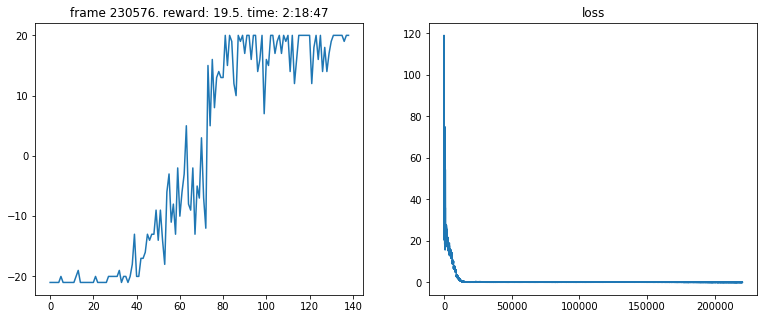

In [6]:
start=timer()

env_id = "PongNoFrameskip-v4"
env    = make_atari(env_id)
env    = wrap_deepmind(env, frame_stack=False)
env    = wrap_pytorch(env)
model = Model(env=env, config=config)

episode_reward = 0

observation = env.reset()
for frame_idx in range(1, config.MAX_FRAMES + 1):
    action = model.get_action(observation)
    prev_observation=observation
    observation, reward, done, _ = env.step(action)
    observation = None if done else observation

    model.update(prev_observation, action, reward, observation, frame_idx)
    episode_reward += reward

    if done:
        model.finish_nstep()
        model.reset_hx()
        observation = env.reset()
        model.save_reward(episode_reward)
        episode_reward = 0
        
        if np.mean(model.rewards[-10:]) > 19:
            plot(frame_idx, all_rewards, losses, timedelta(seconds=int(timer()-start)))
            break

    if frame_idx % 10000 == 0:
        plot(frame_idx, model.rewards, model.losses, model.sigma_parameter_mag, timedelta(seconds=int(timer()-start)))

model.save_w()
env.close()